In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agnet', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [3]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "data/lenet_mnist_model.pth"
use_cuda = True

In [4]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)
  
  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

In [5]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
                   batch_size=1, shuffle=True
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [6]:
print("CUDA available: ", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA available:  True


In [7]:
model = Net().to(device)
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

<All keys matched successfully>

In [8]:
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [9]:
def fgsm_attack(image, epsilon, data_grad):
  sign_data_grad = data_grad.sign()
  perturbed_image = image + epsilon*sign_data_grad
  perturbed_image = torch.clamp(perturbed_image, 0, 1)
  return perturbed_image

In [14]:
def test(model, device, test_loader, epsilon):
  correct = 0
  adv_examples = []

  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    output = model(data)
    init_pred = output.max(1, keepdim=True)[1]

    if init_pred.item() != target.item():
      continue
    
    loss = F.nll_loss(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    perturbed_data = fgsm_attack(data, epsilon, data_grad)
    output = model(perturbed_data)
    final_pred = output.max(1, keepdim=True)[1]

    if final_pred.item() == target.item():
      correct += 1
      if (epsilon == 0) and (len(adv_examples) < 5):
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
    else:
        if len(adv_examples) < 5:
          adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
          adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
        
  final_acc = correct/len(test_loader)
  print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}")

  return final_acc, adv_examples

In [15]:
accuracies = []
examples = []

for eps in epsilons:
  acc, ex = test(model, device, test_loader, eps)
  accuracies.append(acc)
  examples.append(ex)

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9426 / 10000 = 0.9426
Epsilon: 0.1	Test Accuracy = 8510 / 10000 = 0.851
Epsilon: 0.15	Test Accuracy = 6826 / 10000 = 0.6826
Epsilon: 0.2	Test Accuracy = 4301 / 10000 = 0.4301
Epsilon: 0.25	Test Accuracy = 2082 / 10000 = 0.2082
Epsilon: 0.3	Test Accuracy = 869 / 10000 = 0.0869


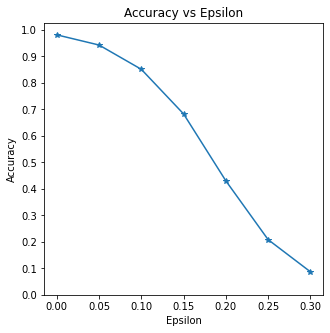

In [16]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

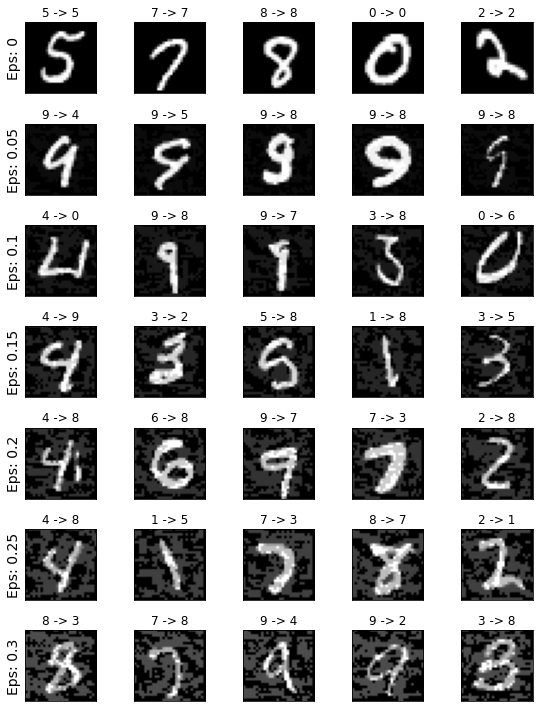

In [17]:
cnt = 0
plt.figure(figsize=(8, 10))
for i in range(len(epsilons)):
  for j in range(len(examples[i])):
    cnt += 1
    plt.subplot(len(epsilons), len(examples[0]), cnt)
    plt.xticks([], [])
    plt.yticks([], [])
    if j == 0:
      plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
    orig, adv, ex = examples[i][j]
    plt.title(f"{orig} -> {adv}")
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()